# MAGGNN model inspection

This notebook can be used to inspect a trained MAGNN model. It assumes you have ran the `run_PPMI.py` succesfully.

In [2]:
from model import MAGNN_nc_mb
import pickle
from utils.data import load_PPMI_data
from utils.tools import index_generator, evaluate_results_nc, parse_minibatch
from pathlib import Path

from sklearn.manifold import TSNE

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_utils as du
data_dir = du.find_data_dir('app')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

Using backend: pytorch
/home/service/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load model parameters

In [7]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()
features_list = [torch.FloatTensor(features).to(device) for features in features_list]

save_state = 'PPMI'
feats_type = 0
n_metapaths = 2
etypes_list = [[0, 1, 0], [0, 1, 1, 0]]
hidden_dim = 64
out_dim = 3
num_heads = 8
attn_vec_dim = 128
dropout_rate = 0.5
batch_size = 8
neighbor_samples = 100
rnn_type = 'RotatE0'

if feats_type == 0:
    in_dims = [features.shape[1] for features in features_list]
elif feats_type == 1:
    in_dims = [features_list[0].shape[1]] + [10] * (len(features_list) - 1)
    for i in range(1, len(features_list)):
        features_list[i] = torch.zeros((features_list[i].shape[0], 10)).to(device)
elif feats_type == 2:
    in_dims = [features.shape[0] for features in features_list]
    in_dims[0] = features_list[0].shape[1]
    for i in range(1, len(features_list)):
        dim = features_list[i].shape[0]
        indices = np.vstack((np.arange(dim), np.arange(dim)))
        indices = torch.LongTensor(indices)
        values = torch.FloatTensor(np.ones(dim))
        features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
elif feats_type == 3:
    in_dims = [features.shape[0] for features in features_list]
    for i in range(len(features_list)):
        dim = features_list[i].shape[0]
        indices = np.vstack((np.arange(dim), np.arange(dim)))
        indices = torch.LongTensor(indices)
        values = torch.FloatTensor(np.ones(dim))
        features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    
    
labels = torch.LongTensor(labels).to(device)
            
net = MAGNN_nc_mb(n_metapaths, 2, etypes_list, in_dims, hidden_dim, out_dim, num_heads, attn_vec_dim, rnn_type, dropout_rate)

train_idx = train_val_test_idx['train_idx']
train_idx = np.sort(train_idx)
test_idx = train_val_test_idx['test_idx']
test_idx = np.sort(test_idx)
val_idx = train_val_test_idx['val_idx']
val_idx = np.sort(val_idx)

net.load_state_dict(torch.load(f'checkpoint/checkpoint_{save_state}.pt'))

<All keys matched successfully>

## Evaluate train-val-test performance

In [8]:
def evaluate_model(idx, train_val_test):
    print(f'Evaluating results for {train_val_test}')
    idx_generator = index_generator(batch_size=batch_size, indices=idx, shuffle=False)
    net.eval()
    embeddings = []
    with torch.no_grad():
        for iteration in range(idx_generator.num_iterations()):
            # forward
            idx_batch = idx_generator.next()
            g_list, indices_list, idx_batch_mapped_list = parse_minibatch(adjlists,
                                                                                         edge_metapath_indices_list,
                                                                                         idx_batch,
                                                                                         device, neighbor_samples)
            logits, embeddings_i = net((g_list, features_list, type_mask, indices_list, idx_batch_mapped_list))
            embeddings.append(embeddings_i)
        embeddings = torch.cat(embeddings, 0)
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
            embeddings.cpu().numpy(), labels[idx].cpu().numpy(), num_classes=out_dim)   
    print('')
    return embeddings

train_embeddings = evaluate_model(train_idx, 'Train')
val_embeddings = evaluate_model(val_idx, 'Val')    
test_embeddings = evaluate_model(test_idx, 'Test')    

Evaluating results for Train
SVM test
Macro-F1: 0.523327~0.114065 (0.8), 0.552642~0.089996 (0.6), 0.562365~0.046523 (0.4), 0.512416~0.077139 (0.2)
Micro-F1: 0.541176~0.101204 (0.8), 0.560606~0.089124 (0.6), 0.565306~0.047468 (0.4), 0.513846~0.064248 (0.2)
K-means test
NMI: 0.115802~0.007344
ARI: 0.071633~0.000483

Evaluating results for Val
SVM test
Macro-F1: 0.357600~0.114486 (0.8), 0.378264~0.079116 (0.6), 0.326397~0.076316 (0.4), 0.287738~0.049984 (0.2)
Micro-F1: 0.390909~0.107949 (0.8), 0.395455~0.078861 (0.6), 0.333333~0.072979 (0.4), 0.313636~0.044070 (0.2)
K-means test
NMI: 0.034388~0.010217
ARI: -0.009354~0.006560

Evaluating results for Test
SVM test
Macro-F1: 0.399946~0.111860 (0.8), 0.417739~0.091304 (0.6), 0.403657~0.074528 (0.4), 0.378389~0.044589 (0.2)
Micro-F1: 0.421053~0.094150 (0.8), 0.427027~0.092683 (0.6), 0.410714~0.076599 (0.4), 0.390541~0.048517 (0.2)
K-means test
NMI: 0.067828~0.007369
ARI: 0.051421~0.006438



## Visualize embeddings

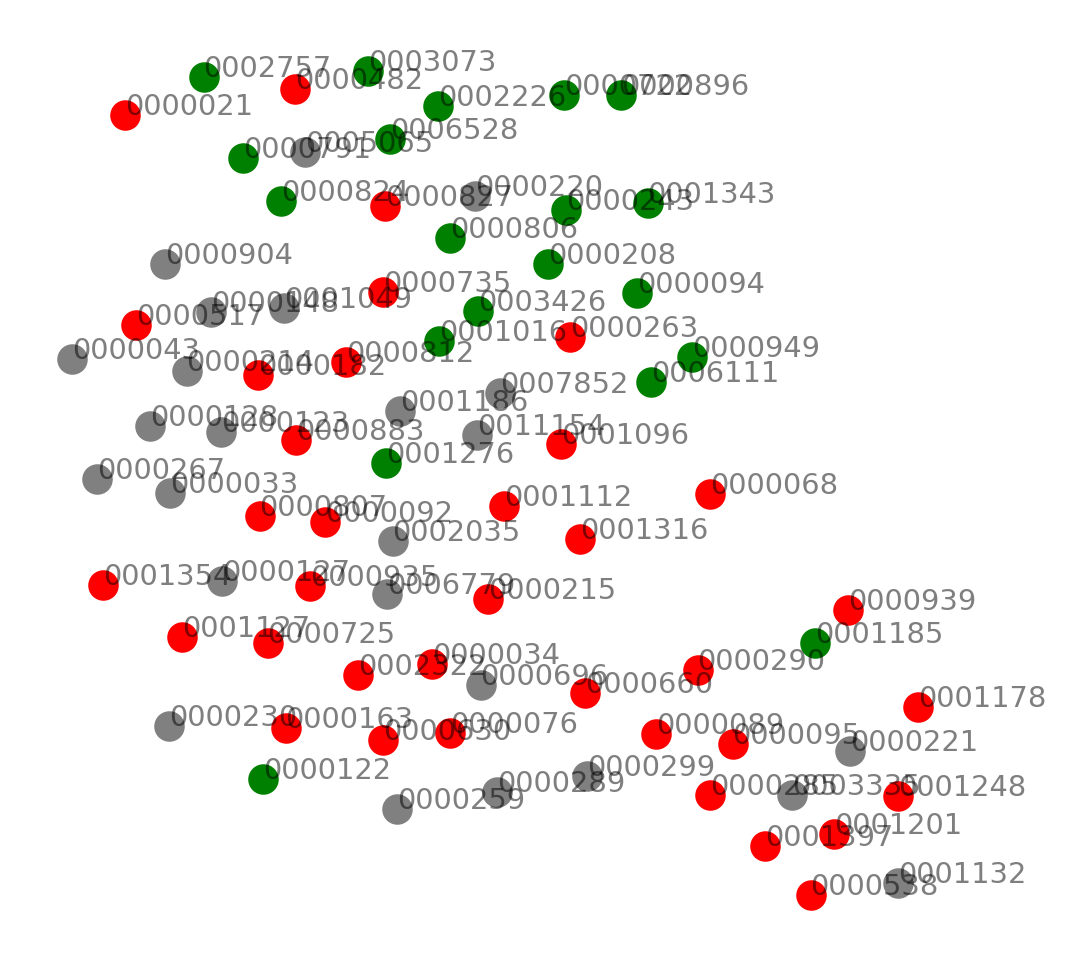

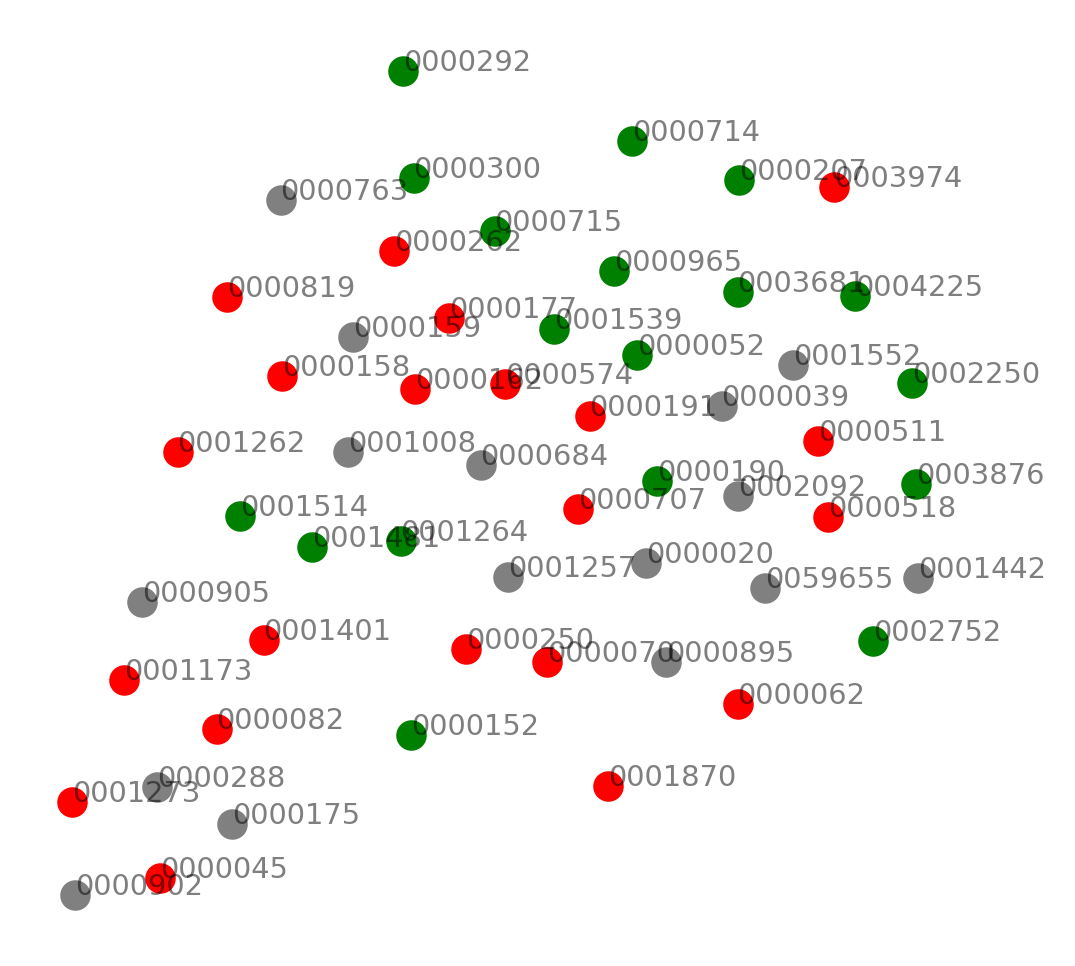

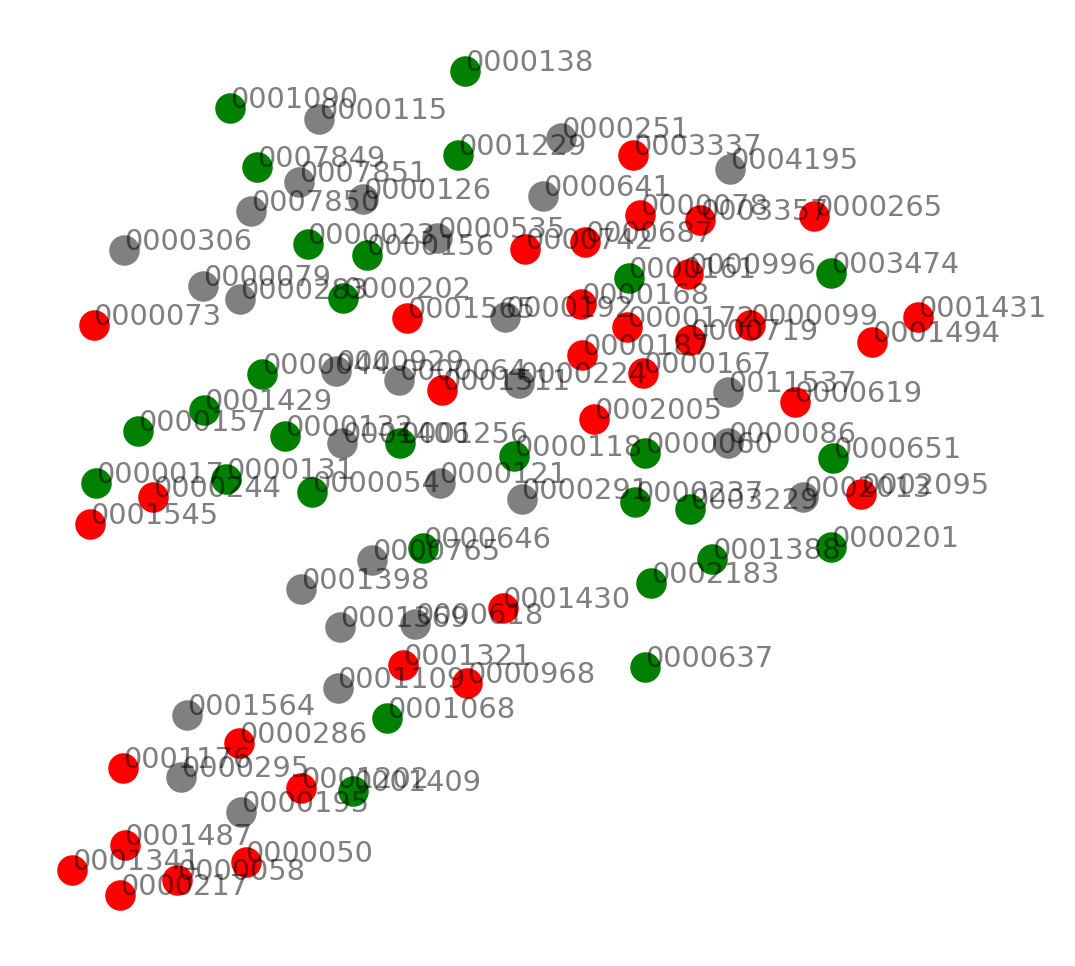

In [13]:
def plot_embedding(embeddings, labels, idx, train_test, method='TSNE', plot_labels=False, CCS=None, highlighted=[], save_fig=False):
    if method=='PCA':
        embedding_2d = torch.pca_lowrank(embeddings, 2)[0]
    elif method=='TSNE':
        embedding_2d = TSNE(n_components=2).fit_transform(embeddings)
    else:
        pass
    
    metabolite_down_mask = np.argwhere(labels[idx]==0)
    metabolite_equal_mask = np.argwhere(labels[idx]==1.)
    metabolite_up_mask = np.argwhere(labels[idx]==2.)

    X_down = embedding_2d[:, 0][metabolite_down_mask][0]
    Y_down = embedding_2d[:, 1][metabolite_down_mask][0]

    X_equal = embedding_2d[:, 0][metabolite_equal_mask][0]
    Y_equal = embedding_2d[:, 1][metabolite_equal_mask][0]
    
    X_up = embedding_2d[:, 0][metabolite_up_mask][0]
    Y_up = embedding_2d[:, 1][metabolite_up_mask][0]
    
    fig = plt.figure(figsize=(4,4), dpi=300)
    fig.patch.set_facecolor('white')    
    
    size = 40
    
    plt.scatter(X_down, Y_down, s=size, c='red', label='CCS = -1')
    plt.scatter(X_equal, Y_equal, s=size, c='gray', label='CCS = 0')
    plt.scatter(X_up, Y_up, s=size, c='green', label='CCS = 1')
    
    if plot_labels:
        fontsize='x-small'
        opacity=.5
        xy_idx_list_down = list(zip(X_down, Y_down, idx[metabolite_down_mask][0]))
        for x, y, i in xy_idx_list_down:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize, alpha=opacity)

        xy_idx_list_equal = list(zip(X_equal, Y_equal, idx[metabolite_equal_mask][0]))
        for x, y, i in xy_idx_list_equal:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize, alpha=opacity)
            
        xy_idx_list_up = list(zip(X_up, Y_up, idx[metabolite_up_mask][0]))
        for x, y, i in xy_idx_list_up:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize, alpha=opacity)
    
#     plt.legend(bbox_to_anchor=(1.04,1), loc='upper left') #Outside graph
#     plt.legend(loc='upper left')
    title = f'Metabolite node embedding | {train_test} | {method}'
#     plt.title(title)
    plt.axis('off')
    
    if save_fig:
        title_stripped = title.replace(' | ', '--')
        filename = f'{title_stripped}.png'
        plt.savefig(Path('figures', filename), bbox_inches='tight')    
    
    plt.show() 
    return embedding_2d, metabolite_down_mask, idx

# highlighted = ['HMDB0000517', 'HMDB0000904']
highlighted=[]

res = plot_embedding(train_embeddings, labels, train_idx, 'Train', method='TSNE', plot_labels=True, CCS=dataloader.y, highlighted=highlighted, save_fig=True)
res = plot_embedding(val_embeddings, labels, val_idx, 'Validation', method='TSNE', plot_labels=True, CCS=dataloader.y, highlighted=highlighted, save_fig=True)
res = plot_embedding(test_embeddings, labels, test_idx, 'Test', method='TSNE', plot_labels=True, CCS=dataloader.y, highlighted=highlighted, save_fig=True)